In [1]:
import json
import numpy as np
import pandas as pd
import os
import h5py
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
X = []
y = []
with h5py.File("behaviours.hdf5", 'r') as ds:
    for i, key in enumerate(ds):
        print("Loading", key)
        X.append(ds[key][...])
        y.append(np.ones(ds[key].shape[0])*i)
        
        
X = np.concatenate(X, axis=0)
X[np.isnan(X)] = 0
y = np.concatenate(y, axis=0)

print(X.shape, y.shape)


#0         "/roboy/middleware/MotorStatus/displacement/3",
#1         "/roboy/middleware/MotorStatus/displacement/5",
#2         "/roboy/middleware/MotorStatus/displacement/6",
#3         "/roboy/middleware/MotorStatus/displacement/10",
#4         "/roboy/middleware/MotorStatus/displacement/12",
#5         "/roboy/middleware/MotorStatus/displacement/13",
#6         "/roboy/middleware/MotorStatus/position/3",
#7         "/roboy/middleware/MotorStatus/position/5",
#8         "/roboy/middleware/MotorStatus/position/6",
#9         "/roboy/middleware/MotorStatus/position/10",
#10         "/roboy/middleware/MotorStatus/position/12",
#11        "/roboy/middleware/MotorStatus/position/13",
#12         '/mocap/MarkerPose/position/x',
#13         '/mocap/MarkerPose/position/y',
#14         '/mocap/MarkerPose/position/z',

Loading frontal_swings_upwards
Loading lateral_rotations_clockwise
Loading marker_up
Loading marker_up_frontal_swing
Loading marker_up_lateral_rotations
Loading marker_up_lateral_swing
Loading motor_marker_1
Loading random_motions
(92514, 15) (92514,)


In [3]:
# Pose information (= motor camera image, (x,y,z) + quaternion)
X_pose = X[:,12:15]   # only the first two components (x, y) have non-zero values
# Motor displacements
X_disp = X[:,0:5]   # last motor component is zero
#X_disp[X_disp < 0] = 0

#Angular position
X_ang = X[:,6:11]   # last motor component is zero
#X_ang[X_ang < 0] = 0


print(X_pose.shape)
print(X_disp.shape)
print(X_ang.shape)

(92514, 3)
(92514, 5)
(92514, 5)


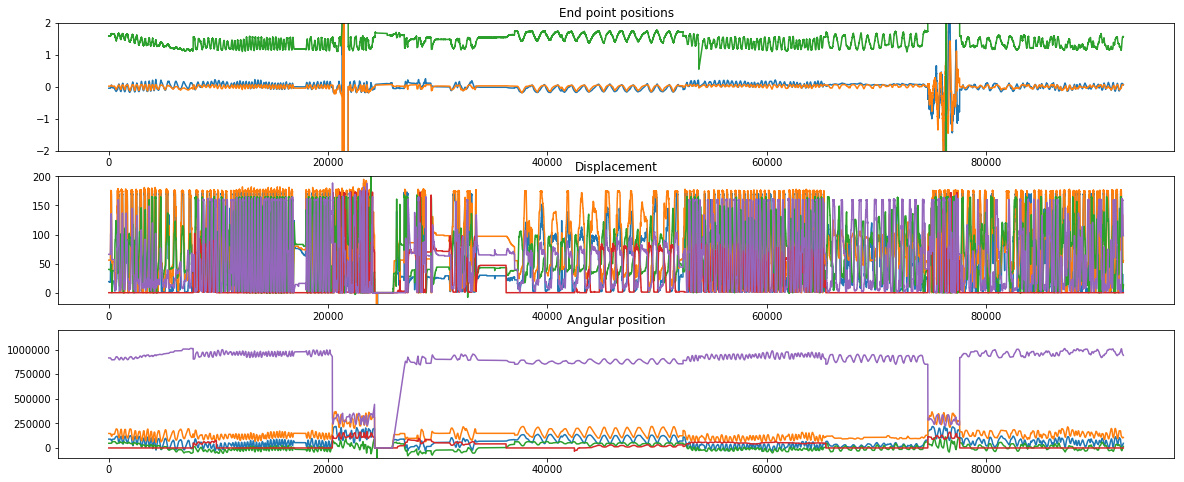

In [4]:

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(3,1,1)
#_, axes = plt.subplots(3,1,figsize=(20,8))

ax1.plot(X_pose)
ax1.set_ylim([-2,2])
ax1.set_title("End point positions")

ax2 = fig.add_subplot(3,1,2)
ax2.plot(X_disp)
ax2.set_ylim([-20,200])
ax2.set_title("Displacement")

ax3 = fig.add_subplot(3,1,3)
ax3.plot(X_ang)
ax3.set_ylim([-100000,1200000])
ax3.set_title("Angular position")
plt.show()
fig.savefig('data')

In [5]:
# removing outliers
for i in range(3):
    X_pose = X_pose[X_pose[:,i] < 2,:]
    X_pose= X_pose[X_pose[:,i] > -2,:]

for i in range(5):
    X_disp = X_disp[X_disp[:,i] < 200,:]
    X_disp= X_disp[X_disp[:,i] > -20,:]
    
for i in range(5):
    X_ang = X_ang[X_ang[:,i] < 1200000,:]
    X_ang= X_ang[X_ang[:,i] > -10000,:]

    
# conversion to tensors    
x = np.array(X_ang)
y = np.array(X_pose)
x  = torch.from_numpy(x)
y = torch.from_numpy(y)

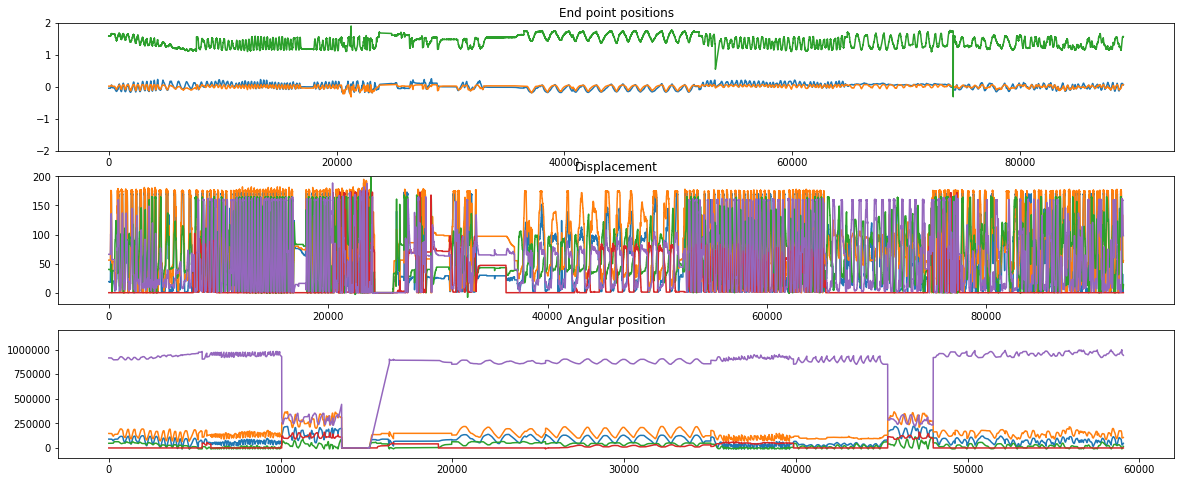

In [6]:
# plotting after removing outliers

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(3,1,1)
#_, axes = plt.subplots(3,1,figsize=(20,8))

ax1.plot(X_pose)
ax1.set_ylim([-2,2])
ax1.set_title("End point positions")

ax2 = fig.add_subplot(3,1,2)
ax2.plot(X_disp)
ax2.set_ylim([-20,200])
ax2.set_title("Displacement")

ax3 = fig.add_subplot(3,1,3)
ax3.plot(X_ang)
ax3.set_ylim([-100000,1200000])
ax3.set_title("Angular position")
plt.show()
fig.savefig('data_clean')

In [68]:
print(len(X_pose))

89056


In [45]:
# Generative Adversarial Networks (GAN) example in PyTorch.
# See related blog post at https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f#.sch4xgsa9
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import random

# Data params
data_mean = 4
data_stddev = 1.25

# Model params
g_input_size = 500     # Random noise dimension coming into generator, per output vector
g_hidden_size = 1000   # Generator complexity
g_output_size = 500    # size of generated output vector
d_input_size = 500   # Minibatch size - cardinality of distributions
d_hidden_size = 1000   # Discriminator complexity
d_output_size = 1    # Single dimension for 'real' vs. 'fake'
minibatch_size = 1

d_learning_rate = 2e-5  # 2e-4
g_learning_rate = 2e-5
optim_betas = (0.9, 0.999)
num_epochs = 3000
print_interval = 200
d_steps = 1  # 'k' steps in the original GAN paper. Can put the discriminator on higher training freq than generator
g_steps = 1

# ### Uncomment only one of these
(name, preprocess, d_input_func) = ("Raw data", lambda data: data, lambda x: x)
#(name, preprocess, d_input_func) = ("Data and variances", lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)

print("Using data [%s]" % (name))

# ##### DATA: Target data and generator input data

def get_distribution_sampler(mu, sigma):
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))  # Gaussian

def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)  # Uniform-dist data into generator, _NOT_ Gaussian

# ##### MODELS: Generator model and discriminator model

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.elu(self.map2(x))
        return F.elu(self.map3(x))

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        nn.BatchNorm2d(128)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.elu(self.map2(x))
        return F.sigmoid(self.map3(x))

def extract(v):
    return v.data.storage().tolist()

def stats(d):
    return [np.mean(d), np.std(d)]

def decorate_with_diffs(data, exponent):
    mean = torch.mean(data.data, 1, keepdim=True)    
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    return torch.cat([data, diffs], 1)   #

# .t() returns the same variable but with transposed data

d_sampler = get_distribution_sampler(data_mean, data_stddev)
gi_sampler = get_generator_input_sampler()
G = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)
D = Discriminator(input_size=d_input_func(d_input_size), hidden_size=d_hidden_size, output_size=d_output_size)
criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
#criterion = nn.MSELoss()
d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)

mus_d = torch.zeros(num_epochs,5)
stds_d = torch.zeros(num_epochs,5)
mus_g = torch.zeros(num_epochs,5)
stds_g = torch.zeros(num_epochs,5)


for epoch in range(num_epochs):
    for d_index in range(d_steps):
        # 1. Train D on real+fake
        D.zero_grad()

        #  1A: Train D on real
        #d_real_data = Variable(d_sampler(d_input_size)) # 100 points Variable
        start  = random.sample(range(0, len(X_ang)-101), 1)[0]
        end = start + 100
        
        d_real_data = x[start:end,:]
        
        mus_d[epoch,:] = torch.mean(d_real_data,0)
        stds_d[epoch,:] = torch.std(d_real_data,0)
        
        d_real_data =  Variable(d_real_data.resize_((1,500))) #500 points
        d_real_data  = d_real_data.type(torch.FloatTensor)
        #print(d_real_data)
        d_real_decision = D(preprocess(d_real_data))  # 1 point Variable
        d_real_error = criterion(d_real_decision, Variable(torch.ones(1)))  # ones = true
        d_real_error.backward() # compute/store gradients, but don't change params

        #  1B: Train D on fake
        d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size)) #100 points variable
        d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels. #100x5 points
        #d_fake_data.data =  d_fake_data.data.resize_((1,500)) #500 points
        d_fake_decision = D(preprocess(d_fake_data))   # 1 point
        d_fake_error = criterion(d_fake_decision, Variable(torch.zeros(1)))  # zeros = fake
        d_fake_error.backward()
        d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

    for g_index in range(g_steps):
        # 2. Train G on D's response (but DO NOT train D on these labels)
        G.zero_grad()

        gen_input = Variable(gi_sampler(minibatch_size, g_input_size))  #100 points
        g_fake_data = G(gen_input)   # 100 x 5 points
        
        #g_fake_data.data = g_fake_data.data.resize_((1,500))
        g_fake_data  = g_fake_data.type(torch.FloatTensor)
        
        dg_fake_decision = D(preprocess(g_fake_data))  # 1 point
        g_error = criterion(dg_fake_decision, Variable(torch.ones(1)))  # we want to fool, so pretend it's all genuine
        
        #print(g_error)
        g_error.backward()
        g_optimizer.step()  # Only optimizes G's parameters
        
        mus_g[epoch,:] = torch.mean(g_fake_data.data.resize_((100,5)),0)
        stds_g[epoch,:] = torch.std(g_fake_data.data.resize_((100,5)),0)
    
    if epoch % print_interval == 0:
        print("%s: D: %s/%s G: %s (Real: %s, Fake: %s) " % (epoch,
                                                            extract(d_real_error)[0],
                                                            extract(d_fake_error)[0],
                                                            extract(g_error)[0],
                                                            stats(extract(d_real_data)),
                                                            stats(extract(d_fake_data))))



Using data [Raw data]
0: D: 0.7881803512573242/0.0016231368063017726 G: 1.0624099969863892 (Real: [51.721066596984862, 24.024548985842493], Fake: [-0.0022879119891440498, 0.091836571592398344]) 
200: D: 4.0/0.031118949875235558 G: 0.7495498061180115 (Real: [41.256433946847913, 45.93149719457746], Fake: [0.11813632397633046, 1.2422994324959229]) 
400: D: 4.0/0.0532878078520298 G: 0.7083683013916016 (Real: [50.44325094604492, 53.491073860698449], Fake: [0.29699112116661852, 1.352105626128999]) 
600: D: 1.3388315439224243/0.058205097913742065 G: 0.650294303894043 (Real: [0.0, 0.0], Fake: [-0.088741940984502429, 0.89844381149379515]) 
800: D: 4.0/0.01244462002068758 G: 0.8388835191726685 (Real: [56.012, 23.521816596513116], Fake: [-0.026898728676140307, 1.1723447035910544]) 
1000: D: 4.0/0.0033650430850684643 G: 0.92652428150177 (Real: [81.683396249294276, 55.076277643735708], Fake: [0.03138067846186459, 1.1493888480495984]) 
1200: D: 4.0/0.002399592660367489 G: 0.9229345917701721 (Real: [

12400: D: 4.0/1.0 G: 4.0 (Real: [66.858249588012697, 51.252524407564906], Fake: [43.727852318882945, 110.47209181813044]) 
12600: D: 4.0/1.0 G: 4.0 (Real: [57.988648222923281, 50.946823130680315], Fake: [43.487170997619629, 109.87812029199799]) 
12800: D: 4.0/1.0 G: 4.0 (Real: [36.024700242996218, 26.971572705206672], Fake: [43.556746407151223, 110.04960635450313]) 
13000: D: 4.0/1.0 G: 4.0 (Real: [101.06412191963196, 68.769994088843646], Fake: [44.694972715377808, 112.86851167396661]) 
13200: D: 4.0/1.0 G: 4.0 (Real: [102.76108906745911, 73.088519867827415], Fake: [46.171451182246209, 116.52297845170915]) 
13400: D: 4.0/1.0 G: 4.0 (Real: [45.97069277572632, 36.693725596569024], Fake: [42.322381568551066, 106.993814028025]) 
13600: D: 4.0/1.0 G: 4.0 (Real: [18.052128273010254, 16.83469539169079], Fake: [45.601529642343522, 115.11161117820852]) 
13800: D: 4.0/1.0 G: 4.0 (Real: [66.625980802536006, 69.185338337643643], Fake: [45.463218955636023, 114.77494737877268]) 
14000: D: 4.0/1.0 G:

KeyboardInterrupt: 

In [9]:
print(d_real_data.data.shape) 

torch.Size([1, 500])


Text(0.5,1,'standard deviation')

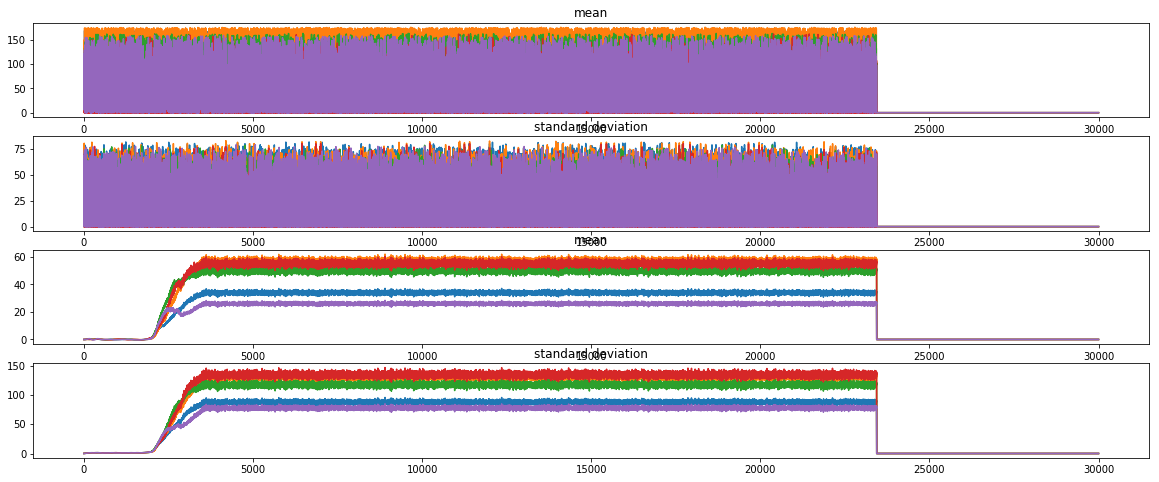

In [48]:
#plotting the output of generator function

fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(4,1,1)
ax1.plot(mus_d.numpy())
#ax1.set_ylim([-2,2])
ax1.set_title("mean")

ax2 = fig.add_subplot(4,1,2)
ax2.plot(stds_d.numpy())
#ax2.set_ylim([-20,200])
ax2.set_title("standard deviation")

ax3= fig.add_subplot(4,1,3)
ax3.plot(mus_g.numpy())
#ax1.set_ylim([-2,2])
ax3.set_title("mean")

ax4 = fig.add_subplot(4,1,4)
ax4.plot(stds_g.numpy())
#ax2.set_ylim([-20,200])
ax4.set_title("standard deviation")

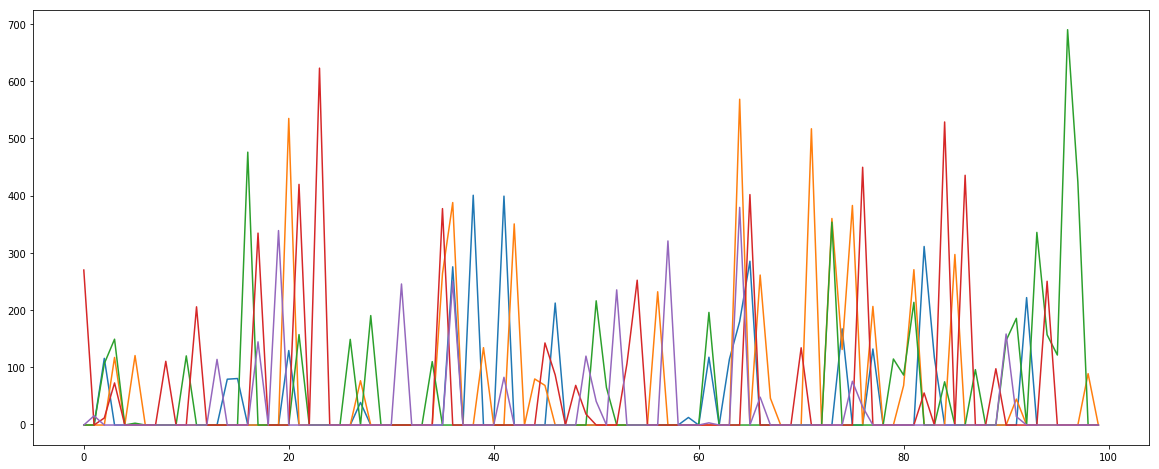

In [57]:
inp = Variable(gi_sampler(minibatch_size, g_input_size))
result = G(inp)
data = result.data.resize_((100,5))
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(data.numpy())
plt.show()
fig.savefig('generated_disp_data')


In [96]:
b = get_distribution_sampler(0, 1)
val = b(10)
print(val.shape)
g = val.numpy()
print(g)
d = val[0,2:4]
print(d)


torch.Size([1, 10])
[[ 1.15387475 -0.38288826 -0.76640564 -0.92195743  1.80269527 -0.06954619
  -1.60150361  1.16960931  0.43478948  0.28135628]]

-0.7664
-0.9220
[torch.FloatTensor of size 2]



In [14]:
a= torch.rand(5,2)
b = a.resize_((1,10))
c = Variable(b)
print(c)

Variable containing:
 0.6362  0.7390  0.6751  0.8641  0.2280  0.0448  0.6161  0.9324  0.0697  0.9402
[torch.FloatTensor of size 1x10]



In [100]:
10/2

5.0

In [101]:
10//2

5